In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

Startar nedan med att hämta datasetet Mnist och hämtar in beskrvningen av det för att läsa på dokumentationen.

In [2]:
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

# EDA

Nedan delar jag upp datan i X och y, jag ser till att y inte är strängar utan gör den numersik. 

Jag kontrollerar formatet på datan med shape-funktionen. 

Sedan gör jag en visualisering för att se att det ser rimligt ut. Jag formar om bilderna så att dem förjer fomratet 28 x 28 pixlar. Skriver ut dem som vit bakgrund med svart siffra, trots att datasetet egentligen är svart bakgrund med vit siffra. Det här är värt att komma ihåg för senare i projektet när vi ska skapa en app tex, viktigt att se till att indatan följer samma representation som träningsdatan.

jag väljer även att visualisera ut fler siffror för att se hur dem alla ser ut och itne bara kollar på en.

(70000, 784)
(70000,)
Sanna värdet på bilden är: 5


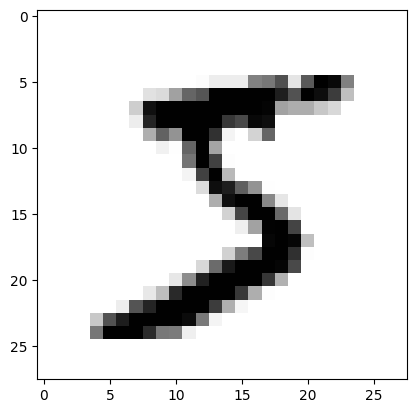

In [3]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)
print(X.shape)
print(y.shape)

# 
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)

print("Sanna värdet på bilden är:", y[0])


Här får jag medge att jag nedan använde lite hjälp av AI för att hitta hur jag kunde skriva ut från siffa 0 till 9. istället för att ändra värdena i bilden ovan och köra om koden hela tiden. 

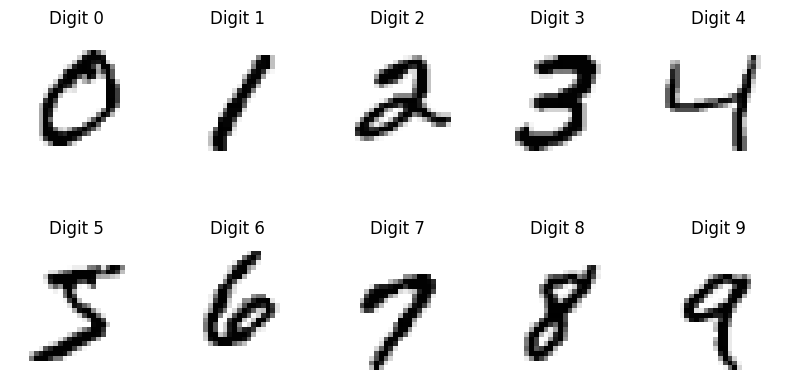

In [4]:
#
fig, axes = plt.subplots(2, 5, figsize=(10,5))

for i, ax in enumerate(axes.flat):
    idx = (y == i).nonzero()[0][0]
    ax.imshow(X[idx].reshape(28,28), cmap="binary")
    ax.set_title(f"Digit {i}")
    ax.axis("off")

plt.show()

Då bilderna är uppdelade i pixlar kan vi se hur dessa pixlar är värderade. det gör vi nedan. Då kan vi se att lägsta pixelvärdet är 0 vilket innebär att det är svart och högssta pixelvärde är 255 vilket innebär helt vitt. Via visualiseringen kan vi se fördelningen och förstå att 0 (avart) har den största andelen sedan kommer 255 som då är vitt. Utöver det ser vi att det finns några färre värden mellan 0-255 vilket tyder på att det är mer eller mindre intensivt. Med hjälp av detta kan vi förstå hur vi kan förbehandla vår data innan vi tränar modellerna. Det kan vara lämpligt att skala vår data. 

In [5]:
#
print("Min pixel value:", X.min())
print("Max pixel value:", X.max())

Min pixel value: 0
Max pixel value: 255


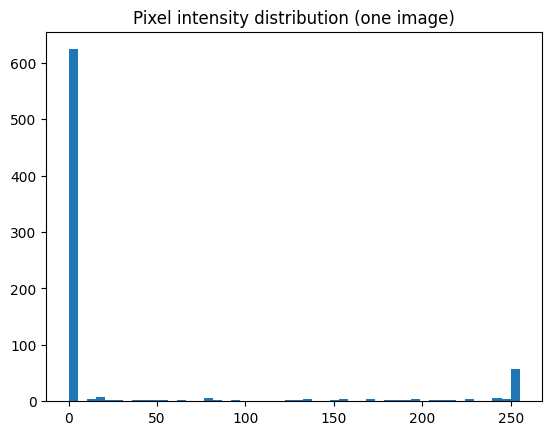

In [6]:
#
plt.hist(X[0], bins=50)
plt.title("Pixel intensity distribution (one image)")
plt.show()

Med hjälp av nedanstående visualsiering kan vi se hur pixlarna varierar genom datasetet, här ser vi att det är stor viariation i mitten av bilden och mindre utmed kanterna. Kanske självklart men anser ändå att det är en bra visulisering för att förstå uppygnaden av bilderna. 

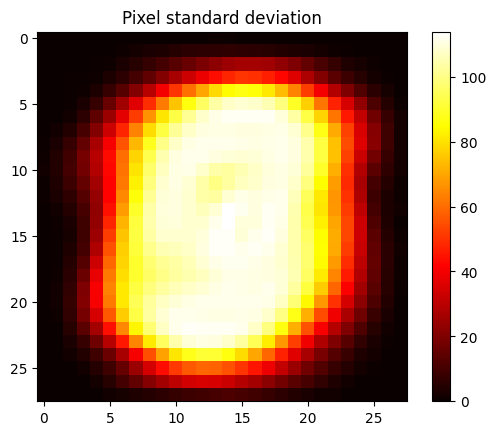

In [7]:
#
std_image = X.std(axis=0)

#
plt.imshow(std_image.reshape(28,28), cmap="hot")
plt.title("Pixel standard deviation")
plt.colorbar()
plt.show()

Utifrån ovanstående kom jag att tänka på hur det ser ut för varje siffra, är det stor variation för dem. Nedan visualiserar jag hur varje siffras varaition ser ut i verkligeheten. Genom att ta medelsiffran för varje klass får vi fram en bild som vissar hur tydligt varje siffra är. 

Här kan vi få en bild av vilka siffror som eventuellt kan bli svårt för modellen att identifiera. Om bilden (siffran) är tydlig innebär det att det är låg variation inom klassen och är den suddig innebär det att det är hög variation. Dem är alla relativt tydliga det är några delar på exemplvis toippen av 6,botten av 4 och 9 som kan ge problem.

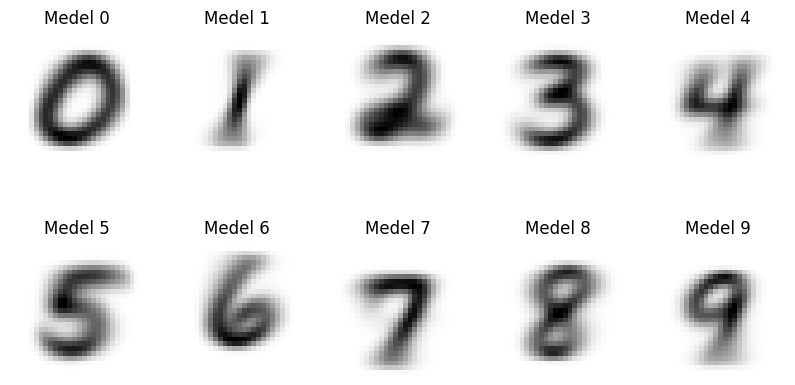

In [8]:
#
fig, axes = plt.subplots(2, 5, figsize=(10,5))

#
for digit in range(10):
    mean_image = X[y == digit].mean(axis=0)
    axes[digit//5, digit%5].imshow(mean_image.reshape(28,28), cmap="binary")
    axes[digit//5, digit%5].set_title(f"Medel {digit}")
    axes[digit//5, digit%5].axis("off")

plt.show()

Jag tar ut och kollar hur många bilder det finns av varje klass(siffra). Vi kan se att datsetet är realtivt jämnfördelat mellan klasserna.

0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64


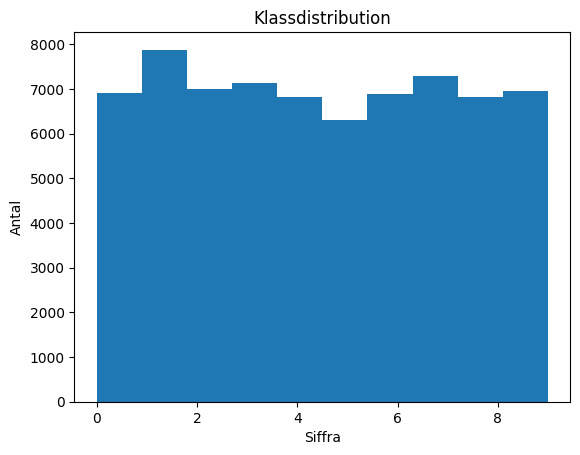

In [9]:
#
print(pd.Series(y).value_counts().sort_index())

#
plt.hist(y, bins=10)
plt.title("Klassdistribution")
plt.xlabel("Siffra")
plt.ylabel("Antal")
plt.show()

MEd hjälp av den inlednande EDAn kan vi se att MNIST bestårt av 70 000 bilder totalt. DEssa bidler är representerade som 784 numeriska features motsvarande formatet 28 x 28 pixlar. Detta innebär att datan är relativt högdimensionellt. 

Det är ett balanserat dataset mellan klasserna(siffrorna 0-9) vilket gör accuracy ett lämpligt initialt utvärderingsmått. Pixelvärdena ligger mellan 0 och 255 i gråskala, vilket innebär att variablerna är kontinuerliga och i vissa fall kan gynnas av att skalas beroende av modell.



Då datasetet har en hög dimensionalitet började jag fundera kring principal component analysis (PCA) för att reducera dimensionerna och potentiellt minska brus. En fördjupad analys visar dock att den mest informativa delen av bilderna redan är koncentrerad till mitten av bildytan medan mbakgrunden i stor utsräckning består av låga eller nollvärden. Vidare kan vald modell reguleras vid behov och PCA innebär en risk för informationsförlust och minskad tolkningsbarhet. Mot denna bakgrund avstår jag från att använda PCA i huvudanalysen, men applicerar det selektivt vid test av mer dimensionskänsliga modeller.

# Modellering

Efter att ha kollat igenom några bilder och se så att allt fungerar ska jag nu dela upp datan i träning/validering och test. Jag kommer ta en tesststorlek på 10000. Detta gör jag efter att  ha läst beskrivningen av datassetet där dem tydligt meddelar att setet består at 60000 träningsbilder och 10000 testbidler. Jag sätter även y som stratify, det här gör jag för att säkerställa att det blir en bättre balans mellan varje siffra i både träningsdatan och testdatan. Risken finns annars att något av seten kan sakna data för en siffra.

In [10]:
from sklearn.model_selection import train_test_split

#
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, stratify=y, random_state=42)

I utvärderingen av modellerna integreras preprocessing direkt i respektive pipeline, detta görs då det i detta fall endast krävs skalning för de numeriska featuresen(variablerna).

Som utvärderingsmått använder jag accuracy och f1-weighted. Accruac ger en övergripande bild av hur stor andel obseravtioner som klassificeras korrekt. 

Eftersom det är multiklassproblem(klassificering av siffrorna 0-9) används vikatade f1-score. Det betyder att f1 score berälnas för varje klass separat och kombinerar precision och recall genom det harmoniksa medelvärdet. Vid f1-weighted tas ett viktat medelvärde av f1-score för samtliga klasser. 

Datsetet MNIST är ett relativt balanserat set, det här innebär att ett viktat f1 score kommer ligga när ett macro f1 score. Jag inkluderar måttet ändå för att visa förståelse för hur man hanterar multiklassproblem och för att säkerställa att modelljämförelsen även är robust vid eventuell klassobalans. 

## Logistisk Regression

Jag börjar med en logistisk regression bara för att lägga en baslinje och något att utgå ifrån. 
Vi kan se att vi får både bra accuracy och f1 score med båda på 0.91. 

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold

#instantierar min pipeline med modelln Logistic regressor
log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

#
cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=42)

#
scoring = ["accuracy", "f1_weighted"]

#
results = cross_validate(
    log_reg_pipe,
    X_train_val, y_train_val,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)


#
log_reg_scores = {m: results[f"test_{m}"].mean()for m in scoring}
print(log_reg_scores)

{'accuracy': np.float64(0.9117666666666668), 'f1_weighted': np.float64(0.9115904223138221)}


## Random Forest

Jag testar även att skapa en random forest och utvärdera, det här gör jag för att kunna fånga upp om det finns mer komplexa möänster i datan. 
vi kan se att vi får både högre accuracy och f1 score med 0.96 på respektive. 
samtidigt som jag får ett bättre resultat funderar jag om det faktiskt är bättre med tanke på tidsåtgången jämfört med logistisk regression. Det här är värt att ta i beaktning om vi ska skapa en framtida applikation. 

In [12]:
from sklearn.ensemble import RandomForestClassifier

#
rand_forrest_pipe = Pipeline([
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=1
    ))
])

#
cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=42)

#
scoring = ["accuracy", "f1_weighted"]

#
results = cross_validate(
    rand_forrest_pipe,
    X_train_val, y_train_val,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

#
rand_forrest_scores = {m: results[f"test_{m}"].mean()for m in scoring}
print(rand_forrest_scores)

{'accuracy': np.float64(0.96885), 'f1_weighted': np.float64(0.9688310398971428)}


## Extra Tree

Jag testar även Extra tree som alternativ till random forest eftersom den introducerar mer slumpmässighet i splitvalet. Det här kan minska variansen och förbättra resultatet. Nedan ser vi att får en accuracy och f1 score på 0.97 för respektive. Men det var marginell förbättring och även här tar den längre tid att köra än random forest. Värt att ta i beaktning för framtiden.



In [13]:
from sklearn.ensemble import ExtraTreesClassifier

#
extra_trees_pipes = Pipeline([
    ("model", ExtraTreesClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=1
    ))
])

#
cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=42)

#
scoring = ["accuracy", "f1_weighted"]

#
results = cross_validate(
    extra_trees_pipes,
    X_train_val, y_train_val,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

#
extra_trees_scores = {m: results[f"test_{m}"].mean()for m in scoring}
print(extra_trees_scores)

{'accuracy': np.float64(0.9721333333333334), 'f1_weighted': np.float64(0.9721207536760044)}


## K-nearest neighbors

Jag testar 

Här får jag ett resultat på 0.94 för både accuracy och f1. KNN hade troligen gett ett bättre resulatat om vi hade förändrat hur siffrorna centreras i bilden. I nuläget är dem centrerade som centre of mass, men vi hade kunnat ändra till centrering med bounding box. Det hade kunant ge ett bättre resultat då knn är käsnligt för förskjutningar i pixelpositioner vilket centre of mass ger mer av jämfört med bouinding box. I detta arbete har jag dock valt att använda standard preprocessing för att behålla jämfölrbarheten med originaldatan. 

In [14]:
from sklearn.neighbors import KNeighborsClassifier

#
knn_pipes = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=3))
])

#
cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=42)

#
scoring = ["accuracy", "f1_weighted"]

#
results = cross_validate(
    knn_pipes,
    X_train_val, y_train_val,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

#
knn_scores = {m: results[f"test_{m}"].mean()for m in scoring}
print(knn_scores)

{'accuracy': np.float64(0.9438833333333333), 'f1_weighted': np.float64(0.9437105022547148)}


### Snabb jämförelse mellan alla modeller. 

In [15]:
# Skapar en tabell för resultaten. 
results_table = pd.DataFrame({
    "Logistic Regression": log_reg_scores,
    "Random Forest": rand_forrest_scores,
    "Extra Tree": extra_trees_scores,
    "KNN": knn_scores
}).T

results_table

,accuracy,f1_weighted
Logistic Regression,0.911767,0.911590
Random Forest,0.968850,0.968831
Extra Tree,0.972133,0.972121
KNN,0.943883,0.943711


Tittar vi på resultatet ger extre tree bäst på både accuracy och f1. Men även logistisk regression visade ett relativt bra reusltat vilket innebär att MNIST datan är strukturerad och även lättare modeller kan separera datan. Men dem ensamblebaseerade modellerna visade ett tydligt bättre reusltat vbilekt tyder på att det finns icke-linjära relationer mellan pixlarna och det spelar en viktig roll. Extra trees valdes därför som modell att fortsätta optimera då den kombinerade både hög prestanda med rimlig träningstid. 

Eftersom trädbaserade modeller inte påverkas av multikollinearitet och inte kräver dimensionsreducering, väljer jag att inte använda PCA i huvudmodellen.

## Förbättring av Extra Trees med gridsearch

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#
extra_trees_pipes = Pipeline([
    ("model", ExtraTreesClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=1
))
])

#
cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=42)


# Hyperparametrar
param_grid = {
    "model__n_estimators": [200, 300],
    "model__max_features": ["sqrt", 0.5],
    "model__min_samples_leaf": [1, 2]
}

# Gridsearch
ext_grid = GridSearchCV(
    extra_trees_pipes,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

# Tränar modellen 
ext_grid.fit(X_train_val, y_train_val)

# Skriver ut reusltaten
print("Bästa hyperparametrar", ext_grid.best_params_)
print("Bästa CV accuracy:", ext_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Bästa hyperparametrar {'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__n_estimators': 300}
Bästa CV accuracy: 0.9730833333333333


Efter att ha kört igenom min extra tree med optiumering av hyperparametrar kan vi se att reusltatet förbättras minimalt. Men tiden det tog att träna denna tog nästan 1 timme. Att det var så pass lite förbättring i accuracy innebär att modellens standardinställnignar var bra anpassade till datan.

Det här illustrerar vikten av att titta på och jämföra en modells komplexitet gentemot beräkningkostnad och prestandaförbättring.


## Prediktering och utvärdering

Nu är det dags att slutgiltigt träna modellen på all träningsdata och sedan prediktera och utvärdera reusltatet.

In [42]:
# Lägger bästa modell med bästa Hyperparametrar i en varaibel
ext_best_model = ext_grid.best_estimator_

# träna på all träningsdata
ext_best_model.fit(X_train_val, y_train_val)

# prediktion på testdata
ext_y_pred = ext_best_model.predict(X_test)

In [43]:
from sklearn.metrics import accuracy_score

# Skriver ut slutgiltigt accuracy
print("Test accuracy:", accuracy_score(y_test, ext_y_pred))

Test accuracy: 0.9728


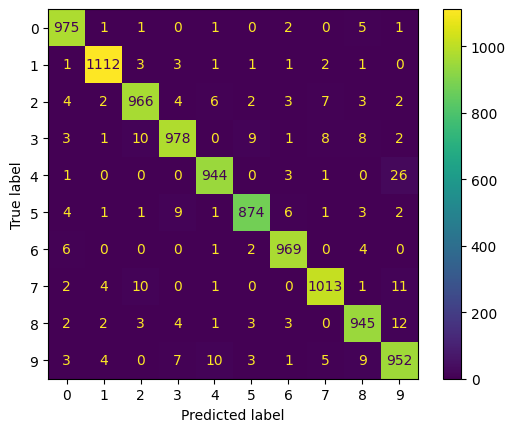

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       986
           1       0.99      0.99      0.99      1125
           2       0.97      0.97      0.97       999
           3       0.97      0.96      0.97      1020
           4       0.98      0.97      0.97       975
           5       0.98      0.97      0.97       902
           6       0.98      0.99      0.98       982
           7       0.98      0.97      0.97      1042
           8       0.97      0.97      0.97       975
           9       0.94      0.96      0.95       994

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


ConfusionMatrixDisplay.from_predictions(y_test, ext_y_pred)
plt.show()

print(classification_report(y_test, ext_y_pred))

## Spara modell

Jag kommer nedan att spara modellen. Detta gört jag för att kunna använda den senare i en applikation.

In [52]:
import joblib

#sparar modell
joblib.dump(ext_best_model, "../models/Extra_trees_mnist_model.pkl")
print("Modell sparad")

Modell sparad


In [46]:
import os
# kontrollera att modellen sparats
print(os.listdir()) 

['kunskapkontroll2.ipynb']


In [47]:
import joblib
#ladda in modellen
ext_loadeed_model = joblib.load("../models/Extra_trees_mnist_model.pkl")
print("Modell laddad")

Modell laddad


In [53]:
# en sista kontroll att den fungerar och har sparats.
ext_loadeed_model.predict(X_test[:5])

array([7, 4, 5, 1, 8], dtype=uint8)

# Bonus
## SVC

Jag väljer att även introducera en SVC modell för att ytterligare undersöka modellprestanda. SVM moddeller har visat sig prestera väldigt starkt på bildklassificeringar som MNIST datasetet. 

Till skillnad från tidigare baslinjemodeller genomför jag hyperparameteroptimering direkt via gridsearch. Detta gör jag för att SVC är käsnlig för valet av hyperparametrar, särskilt regularisering samt kernel. För att kunna utvärdera modellens maximala poetntial och göra en rättvis jämförelse med den tidigare optimerade Extra trees optimeras därför SVC redan från start. 

Jag väljer även att minimera träningsdatan genom subset för att effektivicera beräkningstiden. Detta går bra att göra på MNIST då det är ett relativt välbalanserat datset. 

Inledniongsvis testade jag skalning samt PCA men dessa gav bara en snabbare modell men accuracy blev inte lika hög. Den bästa modellen fanns via rå pixeldata och RBF-kernel med C=10 och gamma="scale" det här indikerar att kernelfunktionen redan hanterar den icke linjära strukturen i datan effektivt. 

In [ ]:

from sklearn.svm import SVC
from sklearn.decomposition import PCA


# Ta ut ett mindre subset för snabbare bearbetning
#rng = np.random.RandomState(42)
#idx = rng.choice(len(X_train_val), size=20000, replace=False)
#X_sub = X_train_val[idx]
#y_sub = y_train_val[idx].ravel()



svc_pipe = Pipeline([
    ("model",SVC(kernel="rbf", random_state=42))
])

param_grid = { 
    "model__C": [10],
    "model__gamma": ["scale"]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

svc_grid = GridSearchCV(
    svc_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=3
)

svc_grid.fit(X_train_val, y_train_val)

print("Bästa hyperparametrar:", svc_grid.best_params_)
print("CV accuracy (subset):", svc_grid.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Bästa hyperparametrar: {'model__C': 10, 'model__gamma': 'scale'}
CV accuracy (subset): 0.9817833333333333


## Prediktion av  och utvärdering av SVC

In [66]:
# slutmodell med bästa hyperparameter tränas på all träningsdata
svc_best_model = svc_grid.best_estimator_
svc_best_model.fit(X_train_val, y_train_val)

# prediktion på testdata
svc_y_pred = svc_best_model.predict(X_test)

# Skriver ut slutgiltigt accuracy
print("Test accuracy:", accuracy_score(y_test, svc_y_pred))

Test accuracy: 0.9836


SVC visar en bättre accuracy än extra tree, jag ställer nedan upp confusion matrix för båda modellerna bredvid varnadra för att jämföra dem. 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

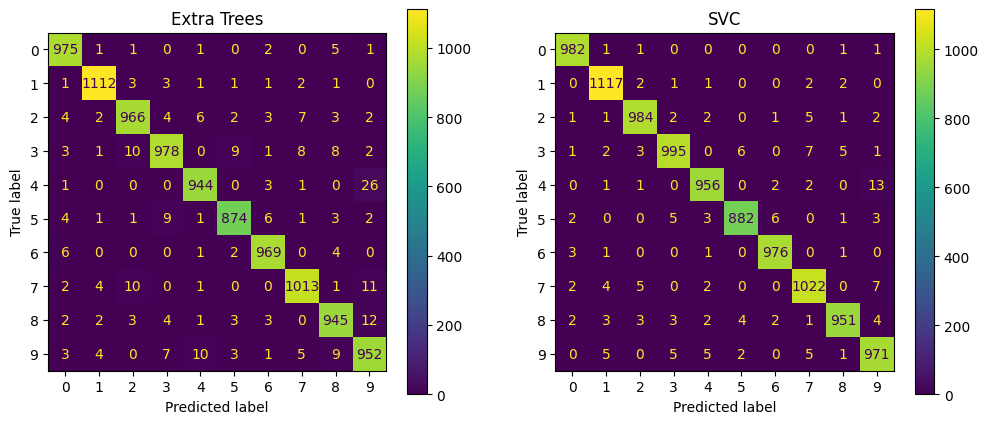

In [68]:
cm_ext = confusion_matrix(y_test, ext_y_pred)
cm_svc = confusion_matrix(y_test, svc_y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_ext).plot(ax=axes[0])
axes[0].set_title("Extra Trees")

ConfusionMatrixDisplay(cm_svc).plot(ax=axes[1])
axes[1].set_title("SVC")

# Classification reports (som text)
axes[1,0].axis("off")
axes[1,0].text(0, 1, classification_report(y_test, svc_y_pred),
               fontsize=10, verticalalignment="top")

axes[1,1].axis("off")
axes[1,1].text(0, 1, classification_report(y_test, ext_y_pred),
               fontsize=10, verticalalignment="top")



plt.tight_layout()
plt.show()

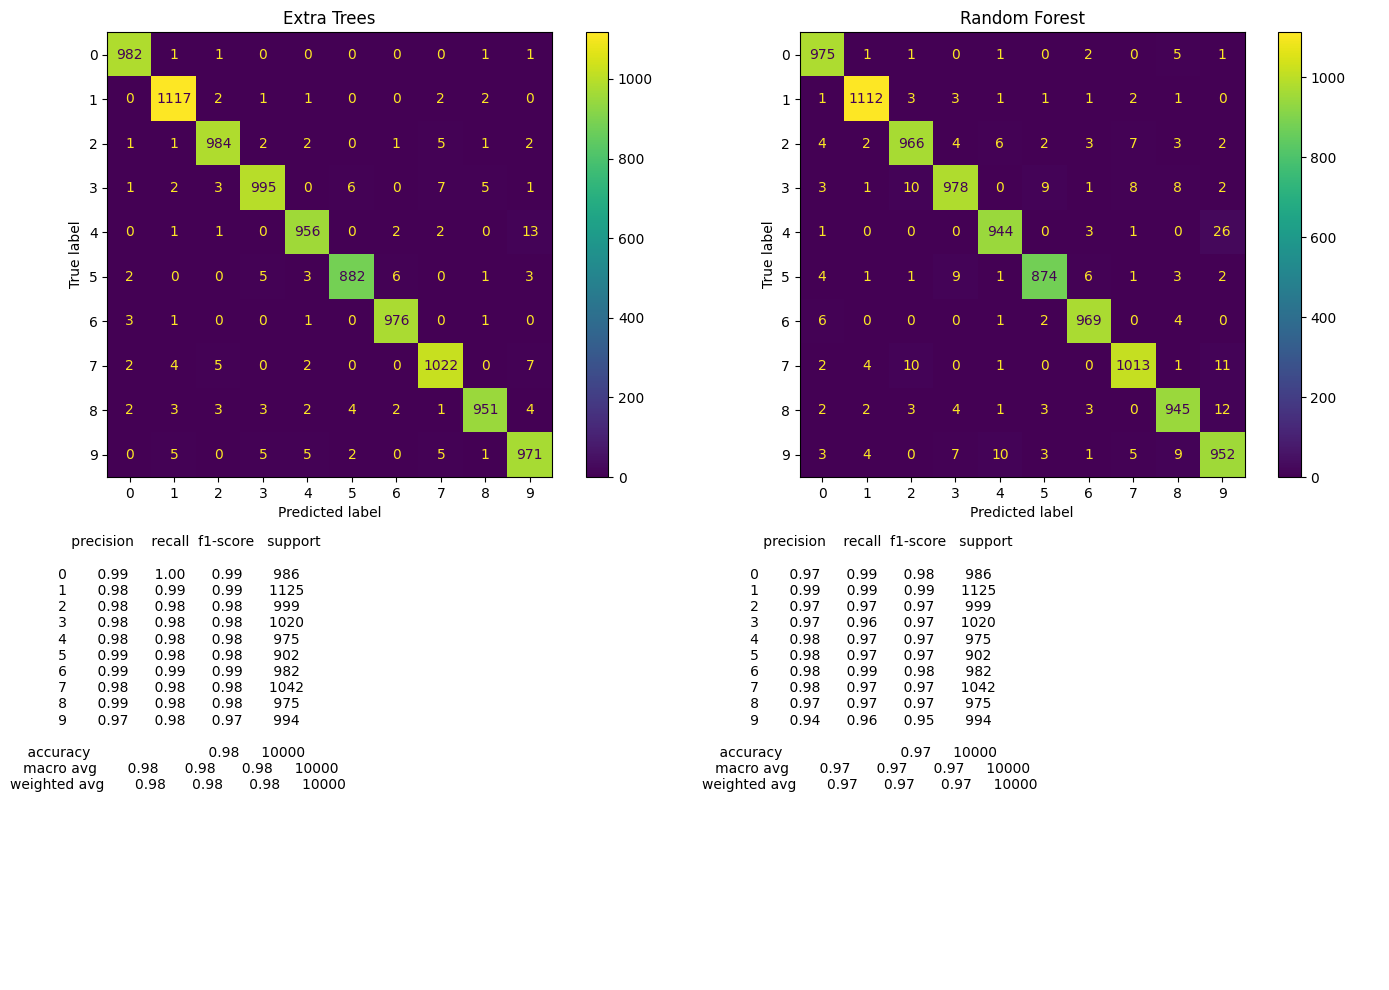

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion matrices
ConfusionMatrixDisplay.from_predictions(y_test, svc_y_pred, ax=axes[0,0])
axes[0,0].set_title("Extra Trees")

ConfusionMatrixDisplay.from_predictions(y_test, ext_y_pred, ax=axes[0,1])
axes[0,1].set_title("Random Forest")

# Classification reports (som text)
axes[1,0].axis("off")
axes[1,0].text(0, 1, classification_report(y_test, svc_y_pred),
               fontsize=10, verticalalignment="top")

axes[1,1].axis("off")
axes[1,1].text(0, 1, classification_report(y_test, ext_y_pred),
               fontsize=10, verticalalignment="top")

plt.tight_layout()
plt.show()

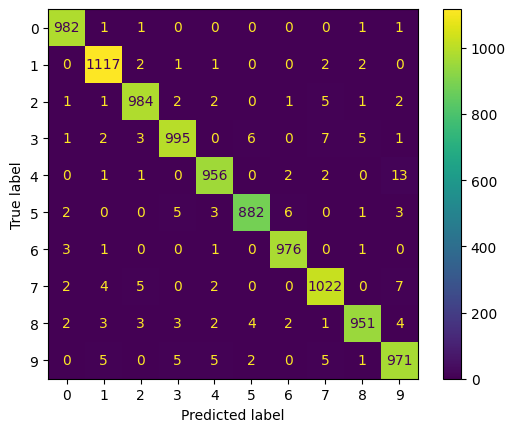

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       986
           1       0.98      0.99      0.99      1125
           2       0.98      0.98      0.98       999
           3       0.98      0.98      0.98      1020
           4       0.98      0.98      0.98       975
           5       0.99      0.98      0.98       902
           6       0.99      0.99      0.99       982
           7       0.98      0.98      0.98      1042
           8       0.99      0.98      0.98       975
           9       0.97      0.98      0.97       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print(classification_report(y_test, svc_y_pred))

Jag sparar även SVC modellen

In [58]:
#sparar modell
joblib.dump(svc_best_model, "../models/SVC_model.pkl")
print("Modell sparad")

Modell sparad


In [59]:
import os
# kontrollera att modellen sparats
print(os.listdir()) 

['kunskapkontroll2.ipynb']


In [60]:
#ladda in modellen
svc_loadeed_model = joblib.load("../models/SVC_model.pkl")
print("Modell laddad")

Modell laddad


In [61]:
# en sista kontroll att den fungerar och har sparats.
svc_loadeed_model.predict(X_test[:5])

array([7, 4, 5, 1, 8], dtype=uint8)

In [63]:
model = joblib.load("../models/Extra_trees_mnist_model.pkl")
print(model)
print(type(model))

Pipeline(steps=[('model',
                 ExtraTreesClassifier(max_features=0.5, n_estimators=300,
                                      n_jobs=1, random_state=42))])
<class 'sklearn.pipeline.Pipeline'>


In [64]:
model = joblib.load("../models/SVC_model.pkl")
print(model)
print(type(model))

Pipeline(steps=[('model', SVC(C=10, random_state=42))])
<class 'sklearn.pipeline.Pipeline'>
